In [1]:
import Dates
println("Last updated: ", Dates.now(), " (PT)")

Last updated: 2020-07-10T11:17:08.821 (PT)


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [3]:
# Import Libraries
using Turing
using Turing: Variational
using Turing.RandomMeasures: stickbreak
using Distributions
using JSON3
using PyPlot
using StatsFuns
import Random
using BenchmarkTools
using Flux

┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1260
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1260


In [4]:
# DP GMM model under stick-breaking construction
@model dp_gmm_sb(y, K) = begin
    nobs = length(y)

    mu ~ filldist(Normal(0, 3), K)
    sig ~ filldist(Gamma(1, 1/10), K)  # mean = 0.1

    alpha ~ Gamma(1, 1/10)  # mean = 0.1
    v ~ filldist(Beta(1, alpha), K - 1)
    eta = stickbreak(v)

    # NOTE: Slow. And the MCMC gets stuck?
    # y .~ MixtureModel(Normal.(mu, sig), eta)

    # NOTE: Fast, and seems to mix well.
    log_target = logsumexp(normlogpdf.(mu', sig', y) .+ log.(eta)', dims=2)
    Turing.acclogp!(_varinfo, sum(log_target))
end

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /home/ubuntu/.julia/packages/DynamicPPL/MRwtL/src/compiler.jl:181


DynamicPPL.ModelGen{var"###generator#409",(:y, :K),(),Tuple{}}(##generator#409, NamedTuple())

In [5]:
# Directory where all simulation data are stored.
data_dir = joinpath(@__DIR__, "../../data/sim-data")
path_to_data = joinpath(data_dir, "gmm-data-n200.json")

# Load data in JSON format.
data = let
    x = open(f -> read(f, String), path_to_data)
    JSON3.read(x, Dict{Symbol, Vector{Any}})
end

Dict{Symbol,Array{Any,1}} with 5 entries:
  :w        => Any[0.220078, 0.291918, 0.2498, 0.238204]
  :mu       => Any[-1.47027, -0.46176, 0.440237, 1.49896]
  :sig      => Any[0.148861, 0.121097, 0.195192, 0.19999]
  :y        => Any[-0.643664, -0.506898, -0.616358, -1.37424, -0.230964, -1.706…
  :rand_idx => Any[2, 2, 2, 1, 2, 1, 4, 4, 2, 4  …  3, 2, 4, 1, 3, 4, 2, 2, 2, …

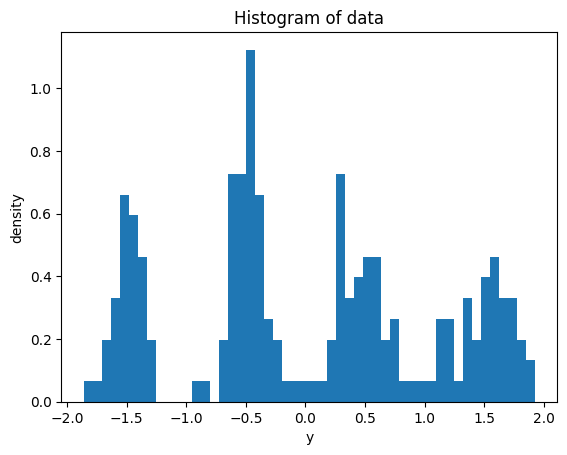

In [6]:
# Convert data to vector of floats
y = Float64.(data[:y]);

# Visualize data
plt.hist(y, bins=50, density=true)
plt.xlabel("y")
plt.ylabel("density")
plt.title("Histogram of data");

In [7]:
# Fit DP-SB-GMM with ADVI

# Set random seed for reproducibility
Random.seed!(10);

# Compile time approx: 1s
# Run time approx: 8s

# Define mean approximation for posterior
m = dp_gmm_sb(y, 10)
q0 = Variational.meanfield(m)  # initialize variational distribution (optional)
advi = ADVI(1, 2000)  # num_elbo_samples, max_iters
@time q = vi(m, advi, q0, optimizer=Flux.ADAM(1e-2));

# NOTE: I can't get the other optimizers to work. 
# So the timings may be overestimated.
# @time q = vi(m, advi, optimizer=RMSProp());  # a little slower, inference not as good.

[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:05


 13.541657 seconds (27.10 M allocations: 6.759 GiB, 5.70% gc time)


In [8]:
# Function for generating samples from approximate posterior
nsamples = 1000
qsamples = rand(q, nsamples)
_, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
extract(sym) = qsamples[collect(sym2range[sym][1]), :]

# Extract eta
vpost = extract(:v)
etapost = hcat([stickbreak(vpost[:, col]) for col in 1:size(vpost, 2)]...)';

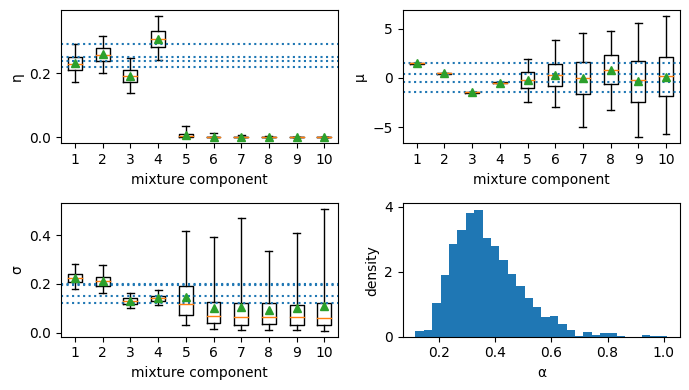

In [9]:
plt.figure(figsize=(7, 4))

plt.subplot(2, 2, 1)
plt.boxplot(etapost, whis=[2.5, 97.5], showmeans=true, showfliers=false);
foreach(line -> plt.axhline(line, ls=":"), data[:w])
plt.xlabel("mixture component")
plt.ylabel("η")

plt.subplot(2, 2, 2)
plt.boxplot(extract(:mu)', whis=[2.5, 97.5], showmeans=true, showfliers=false);
foreach(line -> plt.axhline(line, ls=":"), data[:mu])
plt.xlabel("mixture component")
plt.ylabel("μ")

plt.subplot(2, 2, 3)
plt.boxplot(extract(:sig)', whis=[2.5, 97.5], showmeans=true, showfliers=false);
foreach(line -> plt.axhline(line, ls=":"), data[:sig])
plt.xlabel("mixture component")
plt.ylabel("σ")

plt.subplot(2, 2, 4)
plt.hist(extract(:alpha)', density=true, bins=30)
plt.xlabel("α")
plt.ylabel("density")

plt.tight_layout();

In [27]:
function extract(chain, sym; burn=0, is_scalar=true)
    if is_scalar
        tail = chain[sym].data[(burn + 1):end, 1]
    else
        tail = group(chain, sym).value.data[(burn + 1):end, :, 1]
    end
    return tail
end

extract (generic function with 2 methods)

In [11]:
# Fit DP-SB-GMM with HMC

# Set random seed for reproducibility
Random.seed!(0);

# Compile time approx. 32s.
# Run time approx. 70s.

@time hmc_chain = begin
    burn = 500  # NOTE: The burn in is also returned. Can't be discarded.
    n_samples = 500
    iterations = burn + n_samples
    n_components = 10
    stepsize = 0.01
    nleapfrog = floor(Int, 1 / stepsize)
 
    sample(dp_gmm_sb(y, n_components), 
           HMC(stepsize, nleapfrog),
           iterations)
end
;

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:18


 97.540026 seconds (63.67 M allocations: 122.358 GiB, 8.41% gc time)


In [12]:
# Fit DP-SB-GMM with NUTS

# Set random seed for reproducibility
Random.seed!(0);

# NUTS
# Compile time approx. 11s
# Run time approx. 244s
# Slower, but works a little better.
@time nuts_chain = begin
    n_components = 10
    n_samples = 500
    nadapt = 500
    iterations = n_samples + nadapt
    burn = 0  # For compatibility with HMC below.
    target_accept_ratio = 0.8
    
    sample(dp_gmm_sb(y, n_components),
           NUTS(nadapt, target_accept_ratio, max_depth=10),
           # NUTS(nadapt, target_accept_ratio, max_depth=5),  # 50s, but poor inference.
           iterations);
end
;

┌ Info: Found initial step size
│   ϵ = 0.03688659667968751
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629
Sampling:  40%|████████████████▍                        |  ETA: 0:04:19┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling:  41%|████████████████▉                        |  ETA: 0:04:08┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling:  45%|██████████████████▌                      |  ETA: 0:03:43┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wq

449.334446 seconds (175.93 M allocations: 714.879 GiB, 8.68% gc time)


In [13]:
function plot_param_post(param, param_name, param_full_name; figsize=(11, 4), truth=nothing)
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.boxplot(param, whis=[2.5, 97.5], showmeans=true, showfliers=false)
    plt.xlabel("mixture components")
    plt.ylabel(param_full_name)
    plt.title("95% Credible Intervals for $(param_full_name)")
    
    if truth != nothing
        for line in truth
            plt.axhline(line, ls=":")
        end
    end

    plt.subplot(1, 2, 2)
    plt.plot(param)
    plt.xlabel("iterations")
    plt.ylabel(param_full_name)
    plt.title("Trace plot of $(param_full_name)");
    
    plt.tight_layout();
end

plot_param_post (generic function with 1 method)

In [28]:
function plot_all_params(param; burn, figsize=(11, 4))
    vpost = extract(param, :v, burn=burn, is_scalar=false);
    mupost = extract(param, :mu, burn=burn, is_scalar=false);
    sigpost = extract(param, :sig, burn=burn, is_scalar=false);
    etapost = hcat([stickbreak(vpost[row, :]) for row in 1:size(vpost, 1)]...)';
    
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)

    # Loglikelihood can be extracted after model fitting using string macro.
    # See: https://turing.ml/dev/docs/using-turing/guide#querying-probabilities-from-model-or-chain
    
    # FIXME: not working on master branch.
    # loglike = logprob"y=y, K=n_components | model=dp_gmm_sb, chain=param"
    # plt.plot(loglike[(burn+1):end])
    # plt.xlabel("iteration (post-burn)")
    # plt.ylabel("Log likelihood")

    plt.subplot(1, 2, 2)
    plt.hist(extract(param, :alpha, burn=burn), density=true, bins=30)
    plt.xlabel("α")
    plt.ylabel("density")
    plt.title("Histogram of mass parameter α"); 
    plt.tight_layout();
    
    plot_param_post(etapost, :eta, "mixture weights (η)", truth=data[:w], figsize=figsize);
    plot_param_post(mupost, :mu, "mixture means (μ)", truth=data[:mu], figsize=figsize);
    plot_param_post(sigpost, :sigma, "mixture scales (σ)", truth=data[:sig], figsize=figsize);
end

plot_all_params (generic function with 1 method)

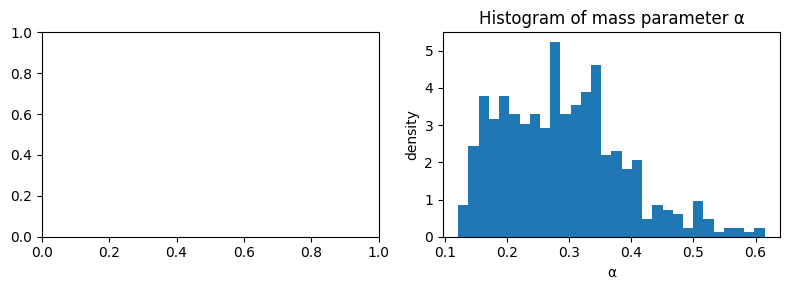

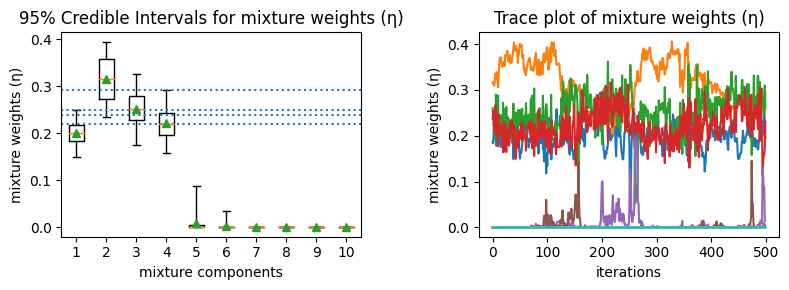

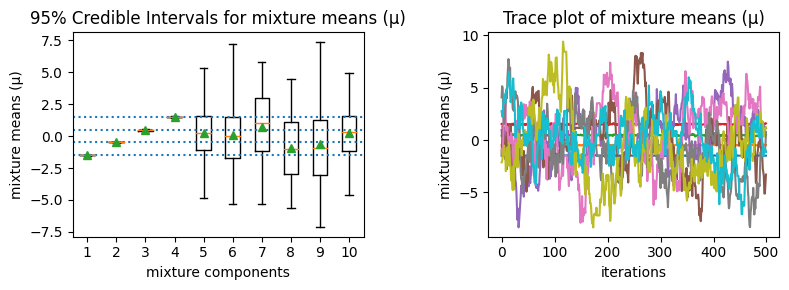

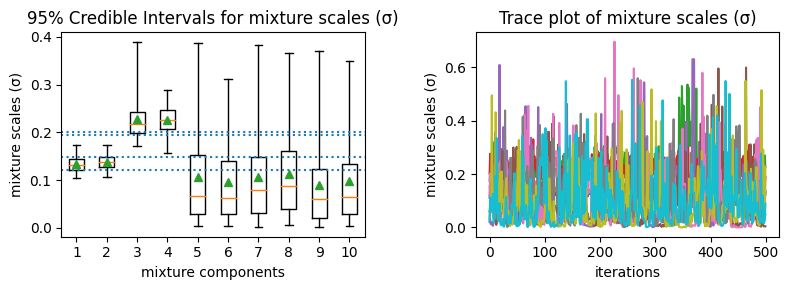

In [29]:
plot_all_params(hmc_chain, burn=500, figsize=(8, 3));

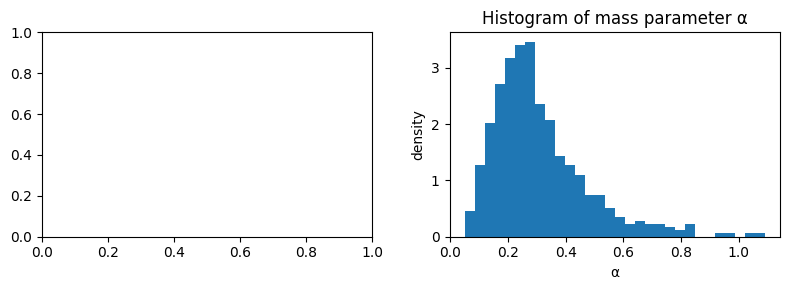

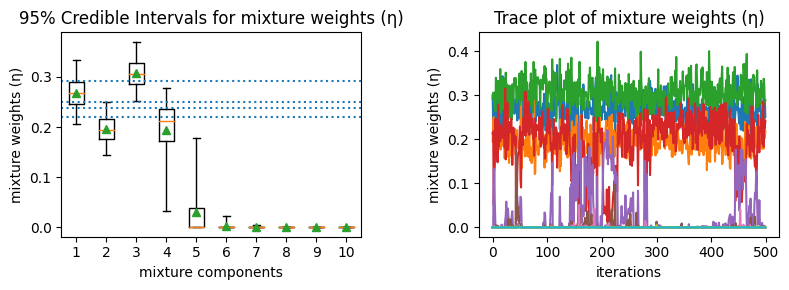

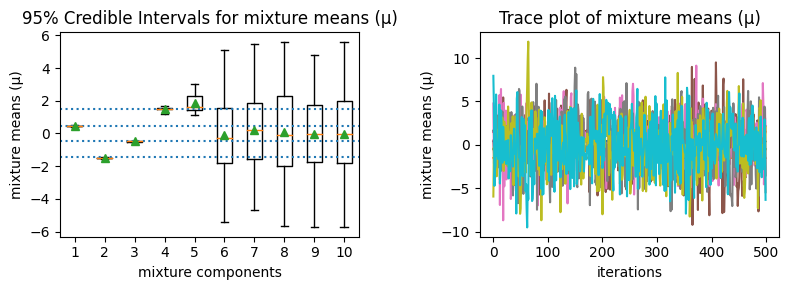

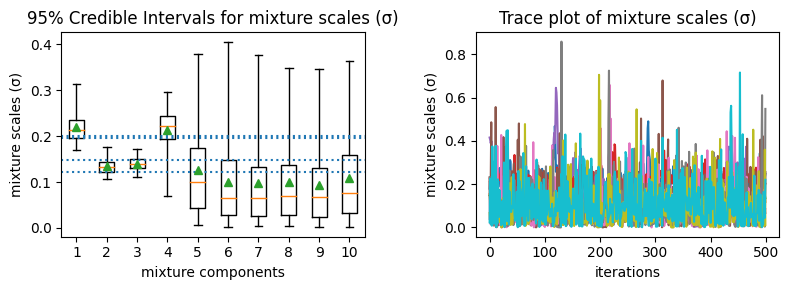

In [30]:
plot_all_params(nuts_chain, burn=0, figsize=(8, 3));